<a href="https://colab.research.google.com/github/RafsanJany-44/ARC/blob/master/Fitabase_Regression_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
!pip install glob2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
from glob import glob
import os
import pandas as pd
path = "/content/drive/MyDrive/Iqram Sir/Fitabase data pulls - seperate"

In [32]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from tqdm.notebook import tqdm

def get_content(patient_folder_adrs):

  post_adrs = sorted(glob(patient_folder_adrs+"/*"))[0]
  

  pre_adrs = sorted(glob(patient_folder_adrs+"/*"))[1]

  for i in glob(post_adrs+"/*"):
    content = i.split("_")
    if "1min" in content:
      post_1min = i
    if "minuteCaloriesNarrow" in content:
      post_cal = i
    if "minuteMETsNarrow" in content:
      post_met = i


  for i in glob(pre_adrs+"/*"):
    content = i.split("_")
    if "1min" in i.split("_"):
      pre_1min = i
    if "minuteCaloriesNarrow" in content:
      pre_cal = i
    if "minuteMETsNarrow" in content:
      pre_met = i
 
  return post_1min, post_cal,post_met, pre_1min, pre_cal, pre_met




def plot(X,Y,m,c,hr_aee = False):
  fig = plt.figure(figsize=(13,8))
  ax = fig.add_subplot()
  fig.subplots_adjust(top=0.85)

  # Set titles for the figure and the subplot respectively
  #fig.suptitle('bold figure suptitle', fontsize=14, fontweight='bold')
  if hr_aee == True:
    ax.set_title('Max HR & aEE',fontweight='bold')
  else:
    ax.set_title('Max HR',fontweight='bold')

  ax.scatter(X, Y)

  high_y = Y.max()

  high_x = (high_y-c)/m

  rang_y=[Y.min(),high_y]

  ax.plot((rang_y-c)/m, rang_y, color = "red")

  ax.scatter(high_x, high_y, color='green')
  ax.annotate('(aEEMax,HRMax)', xy=(high_x, high_y), xytext=(high_x-5, high_y+10),fontweight='bold')
  ax.annotate("("+str(round(high_x[0],2))+","+str(high_y)+")", xy=(high_x, high_y), xytext=(high_x-3, high_y+5),fontweight='bold',color = 'purple')


  if hr_aee == True:
    ax.set_xlabel("aEE_MAX(kJ/min)",fontweight='bold',fontsize=12)
    ax.set_ylabel("HR_MAX(BPM)",fontweight='bold',fontsize=12)
  else:
    ax.set_xlabel("aEE(kJ/min)",fontweight='bold',fontsize=12)
    ax.set_ylabel("HR(BPM)",fontweight='bold',fontsize=12)

  ax.axis([0, high_x+10, 0, high_y+30])

  ax.grid()
  plt.show()




def signle_sample(df_1min, df_cal,df_met,min,hr_aee = False):
  list_1 = list(df_1min["Time"])
  list_2 = list(df_cal["ActivityMinute"])
  #df_met = mets_minute_refine(df_met,min)
  list_3 = list(df_met["ActivityMinute"])


  hr = []
  aee = []
  time = []
  mets = []

  if len(list_1)>len(list_2):
    for i in tqdm(list_1):
      if i in list_2 and i in list_3:
        hr.append(list(df_1min.query("Time == '"+i+"'")['Value'])[0])
        aee.append(list(df_cal.query("ActivityMinute == '"+i+"'")['Calories'])[0]*4.184)
        mets.append(list(df_met.query("ActivityMinute == '"+i+"'")['METs'])[0])
        time.append(i)

  else:
    for i in tqdm(list_2):
      if i in list_1 and i in list_3:
        hr.append(list(df_1min.query("Time == '"+i+"'")['Value'])[0])
        aee.append(list(df_cal.query("ActivityMinute == '"+i+"'")['Calories'])[0]*4.184)
        mets.append(list(df_met.query("ActivityMinute == '"+i+"'")['METs'])[0])
        time.append(i)

  d={
    "Time" : time,
     "HR(BPM)" : hr,
     "aEE(kJ/min)":aee,
     "METs" : mets
  }

  dataFrame = pd.DataFrame.from_dict(d)


  Y = dataFrame["HR(BPM)"].values.reshape(-1, 1)
  X = dataFrame["aEE(kJ/min)"].values.reshape(-1, 1)
  reg = LinearRegression().fit(X, Y)
  m = reg.coef_[0]
  c = reg.intercept_

  if hr_aee == True:
    hr_mx = Y.max()
    aee_mx = (hr_mx-c)/m
    return hr_mx, round(aee_mx[0],2)

  else:
    plot(X,Y,m,c)
    return dataFrame



def test_signle_sample(data,df_1min,df_cal,df_met):
  total_row = data.shape[0]
  print("Total DataRow: ",total_row)

  err_row=[]

  for i in tqdm(range(total_row)):
    print(data["Time"][i], data['HR(BPM)'][i],round(data['aEE(kJ/min)'][i],2),data['METs'][i])

    hr = list(df_1min.query("Time == '"+data["Time"][i]+"'")['Value'])[0]
    cal = round(list(df_cal.query("ActivityMinute == '"+data["Time"][i]+"'")['Calories'])[0],2)
    mets = list(df_met.query("ActivityMinute == '"+data["Time"][i]+"'")['METs'])[0]
    print(hr,round(cal*4.184,2),mets)
    print("------------------------------------------------------------")

    if hr != data['HR(BPM)'][i] or cal != round(data['aEE(kJ/min)'][i]/4.184,2) or mets != data['METs'][i]:
      err_row.append((data["Time"][i],i))
  return err_row







def range_list(k):
  list_of = []
  main_list = []

  for i in range(len(k)-1):
 
    if k[i+1]-k[i] == 1:
      list_of.append(k[i])
    else:
      list_of.append(k[i])
      main_list.append(list_of)
      list_of=[]
    if i == len(k)-2:
      if k[i+1]-k[i] == 1:
        list_of.append(k[i+1])
        main_list.append(list_of)
      else:
        main_list.append([k[i+1]])
  
  return main_list






def mets_minute_refine(data,minutes):

  mets_10 = []
  mets_more = []
  for i in range(data.shape[0]):
    if data["METs"][i] > 10:
      mets_more.append(i)
    else:
      mets_10.append(i)

  main_l = range_list(mets_more)

  removable_list = []
  for i in range(len(main_l)-1):
    if len(main_l[i]) < minutes+1:
      for j in main_l[i]:
        removable_list.append(j)

  df1=data.drop(data.index[mets_10+removable_list]).reset_index()
  return df1





from datetime import datetime

def formate24(t):
  time = t.split(" ")
  m2 = time[1]+" "+time[2]
  in_time = datetime.strptime(m2, "%I:%M:%S %p")
  out_time = datetime.strftime(in_time, "%H:%M:%S")
  return out_time


def dif_min(start_time, end_time):
  t1 = datetime.strptime(start_time, "%H:%M:%S")
  t2 = datetime.strptime(end_time, "%H:%M:%S")

  delta = t2 - t1

  return delta.total_seconds()/60
     


In [44]:
subject = '001-JV'



for i in glob(path+"/*"):
  #get_contenct(i)
  if subject in i.split("/"):
    Post_1min,Post_cal,Post_met, Pre_1min,Pre_cal,Pre_met = get_content(i)

df_post_1min = pd.read_csv(Post_1min)
df_post_cal = pd.read_csv(Post_cal)
df_post_met = pd.read_csv(Post_met)

df_pre_1min = pd.read_csv(Pre_1min)
df_pre_cal = pd.read_csv(Pre_cal)
df_pre_met = pd.read_csv(Pre_met)



  0%|          | 0/50400 [00:00<?, ?it/s]

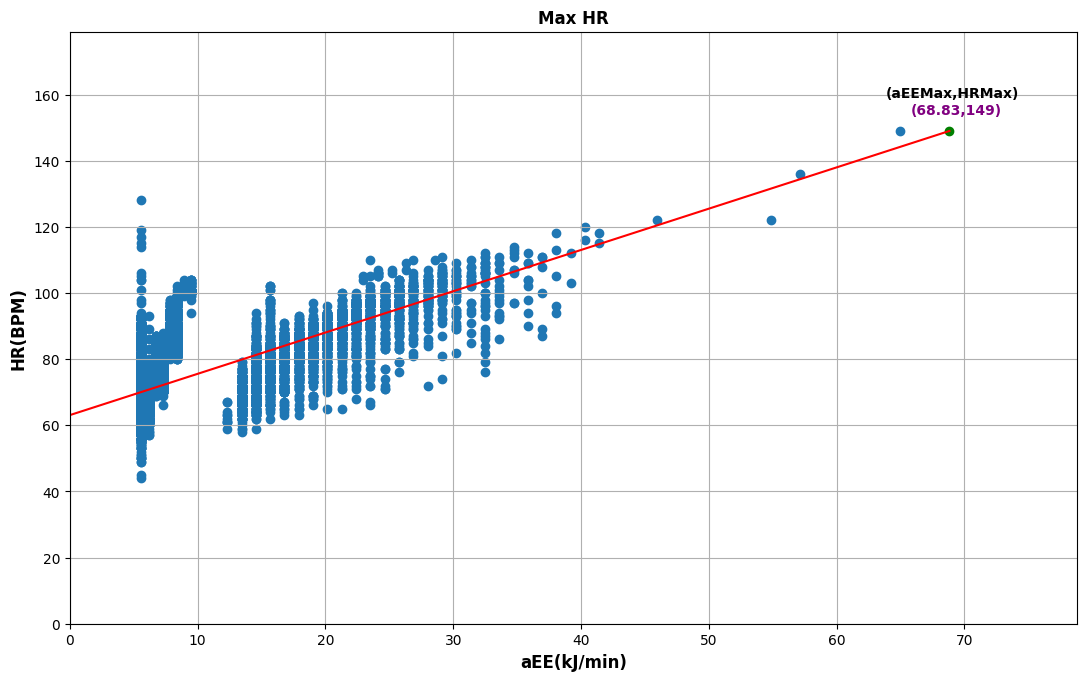

In [34]:
d = signle_sample(df_post_1min,df_post_cal,df_post_met,5)

In [46]:
minute = 5

test_data = mets_minute_refine(d, minute)

test_data.shape

(9313, 5)

In [36]:
test_data.to_csv("Test_METs_Series_001-JV.csv",index = False)

In [101]:


def time_limit_check(test_data,min_limit):
  time_diff_list = []
  for i in tqdm(let):

    start_time = formate24(list(test_data.query("index == "+str(i[0])+"")['Time'])[0])
    end_time = formate24(list(test_data.query("index == "+str(i[-1])+"")['Time'])[0])
    diff = dif_min(start_time,end_time)
    if diff < min_limit:
      time_diff_list.append(i)
  
  return time_diff_list


def single_segment_refine(single_list,min_limit):
  temp = []
  main = []

  for i in range(len(single_list)-1):
    k = formate24(list(test_data.query("index == "+str(single_list[i+1])+"")['Time'])[0])
    l = formate24(list(test_data.query("index == "+str(single_list[i])+"")['Time'])[0])
    diff = dif_min(l,k)
    #print(k,l,diff)
    if diff == 1 or diff == -1439.0:
      temp.append(single_list[i])
      flage = 1
    else:
      temp.append(single_list[i])
      if len(temp) >= min_limit+1:
        
        main.append(temp)
      temp=[]
      flage = 0

  if flage == 1:
    if len(temp) >= min_limit+1:
        main.append(temp)

  return main




In [50]:
print(*time_diff,sep="\n")

[7079, 7088, -478.0]
[14377, 14407, -423.0]
[16169, 16186, -1423.0]
[17861, 17956, -507.0]
[22486, 22742, -378.0]
[24082, 24097, -375.0]
[32546, 32546, 0.0]


In [51]:
print(*time_diff_list,sep="\n")

[7079, 7080, 7081, 7082, 7083, 7084, 7085, 7086, 7087, 7088]
[14377, 14378, 14379, 14380, 14381, 14382, 14383, 14384, 14385, 14386, 14387, 14388, 14389, 14390, 14391, 14392, 14393, 14394, 14395, 14396, 14397, 14398, 14399, 14400, 14401, 14402, 14403, 14404, 14405, 14406, 14407]
[16169, 16170, 16171, 16172, 16173, 16174, 16175, 16176, 16177, 16178, 16179, 16180, 16181, 16182, 16183, 16184, 16185, 16186]
[17861, 17862, 17863, 17864, 17865, 17866, 17867, 17868, 17869, 17870, 17871, 17872, 17873, 17874, 17875, 17876, 17877, 17878, 17879, 17880, 17881, 17882, 17883, 17884, 17885, 17886, 17887, 17888, 17889, 17890, 17891, 17892, 17893, 17894, 17895, 17896, 17897, 17898, 17899, 17900, 17901, 17902, 17903, 17904, 17905, 17906, 17907, 17908, 17909, 17910, 17911, 17912, 17913, 17914, 17915, 17916, 17917, 17918, 17919, 17920, 17921, 17922, 17923, 17924, 17925, 17926, 17927, 17928, 17929, 17930, 17931, 17932, 17933, 17934, 17935, 17936, 17937, 17938, 17939, 17940, 17941, 17942, 17943, 17944, 17945

In [103]:


print(*single_segment_refine(time_diff_list[2],0),sep='\n')

[16169, 16170, 16171, 16172, 16173, 16174, 16175, 16176, 16177, 16178, 16179, 16180, 16181, 16182, 16183, 16184, 16185]
